In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import os
import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
import math

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [3]:
from pprint import pprint
from box import Box

config = {
    'debug': False,
    'name': 'Petfinder',
    'seed': 3407,
    'n_splits': 10,
    'epochs': 5,
    'root': "../datasets/kaggle/petfinder",
    'image_size_tta': 440,
    'image_size': 384,
    'work_dir': './checkpoint',
    'log_level': 'INFO',
    'log_average_filter':['pred', 'label'],
    'log_config': {
        'interval': 10,
        'hooks' : [
            dict(name='PetfinderLoggerHook'),
            # dict(name='TextLoggerHook'),
        ]
    },
    'model': {
        'name': 'swin_large_patch4_window12_384',
        'feature_dim': 128,
        'output_dim': 1,
    },
    'train_loader': {
        'batch_size': 16,
        'num_workers': 10,
        'shuffle': True,
        'drop_last': False,
        'pin_memory': False,
    },
    'val_loader': {
        'batch_size': 16,
        'num_workers': 10,
        'shuffle': False,
        'drop_last': False,
        'pin_memory': False,
    },
    'optimizer': {
        'name': 'AdamW',
        'lr': 1e-5,
    },
    'optimizer_config': {
        'grad_clip': None
    },
    'lr_config': {
        'policy': 'CosineAnnealing',
        'by_epoch': False,
        'min_lr_ratio': 1e-2,
        'warmup': 'linear',
        'warmup_ratio': 1e-3,
        'warmup_iters': 200,
        'warmup_by_epoch': False
    },
    'workflow': [('train', 1), ('val', 1)],
    'checkpoint_config': {
        'interval': 1,
    },
    'earlystopping_config': {
        'monitor': 'mse',
        'patience': 2,
        'mode': 'min',
    }
}


config = Box(config)
pprint(config)

{'checkpoint_config': <Box: {'interval': 1}>,
 'debug': False,
 'earlystopping_config': {'mode': 'min',
                          'monitor': 'mse',
                          'patience': 2},
 'epochs': 5,
 'image_size': 384,
 'image_size_tta': 440,
 'log_average_filter': <BoxList: ['pred', 'label']>,
 'log_config': {'hooks': <BoxList: [{'name': 'PetfinderLoggerHook'}]>,
                'interval': 10},
 'log_level': 'INFO',
 'lr_config': {'by_epoch': False,
               'min_lr_ratio': 0.01,
               'policy': 'CosineAnnealing',
               'warmup': 'linear',
               'warmup_by_epoch': False,
               'warmup_iters': 200,
               'warmup_ratio': 0.001},
 'model': {'feature_dim': 128,
           'name': 'swin_large_patch4_window12_384',
           'output_dim': 1},
 'n_splits': 10,
 'name': 'Petfinder',
 'optimizer': <Box: {'name': 'AdamW', 'lr': 1e-05}>,
 'optimizer_config': <Box: {'grad_clip': None}>,
 'root': '../datasets/kaggle/petfinder',
 'seed': 340

In [4]:
import cv2
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

class PetfinderDataset(Dataset):
    def __init__(
        self, 
        df, 
        transform=None
    ):
        super().__init__()
        self.df = df
        self._X = self.df['file_path']
        self._Y = None
        if 'Pawpularity' in df.keys():
            self._Y = self.df['Pawpularity'].values
        self.transform = transform

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        image_path = self._X[idx]
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        filename = image_path.split('/')[-1]
        if self.transform:
            image = self.transform(image=image)['image']
        if self._Y is not None:
            label = self._Y[idx]
            return {'image': image, 'label': label, 'filename': filename}
        return {'image': image, 'filename': filename}

class PetfinderLoader():
    def __init__(
        self,
        train_df,
        val_df,
        cfg,
    ):
        self._train_df = train_df
        self._val_df = val_df
        self._cfg = cfg

        self.train_transform = A.Compose(
            [
                A.Resize(cfg.image_size, cfg.image_size),
                A.Normalize(
                    mean = [0.485, 0.456, 0.406],
                    std = [0.229, 0.224, 0.225],
                ),
                A.HorizontalFlip(p = 0.5),
                A.VerticalFlip(p = 0.5),
                A.Rotate(limit = 180, p = 0.7),
                A.ShiftScaleRotate(
                    shift_limit = 0.1,
                    scale_limit = 0.1,
                    rotate_limit = 45,
                    p = 0.5
                ),
                A.HueSaturationValue(
                    hue_shift_limit = 0.2,
                    sat_shift_limit = 0.2,
                    val_shift_limit = 0.2,
                    p = 0.5
                ),
                A.RandomBrightnessContrast(
                    brightness_limit = (-0.1, 0.1),
                    contrast_limit = (-0.1, 0.1),
                    p = 0.5
                ),
                ToTensorV2(p=1.0)
            ]
        )

        self.val_transform = A.Compose(
            [
                A.Resize(cfg.image_size, cfg.image_size),
                A.Normalize(
                    mean = [0.485, 0.456, 0.406],
                    std = [0.229, 0.224, 0.225],
                ),
                ToTensorV2(p=1.0)
            ]
        )

        self.test_transform = A.Compose(
            [
                A.Resize(cfg.image_size_tta, cfg.image_size_tta),
                A.Normalize(
                    mean = [0.485, 0.456, 0.406],
                    std = [0.229, 0.224, 0.225],
                ),
                ToTensorV2(p=1.0)
            ]
        )

    def __create_dataset(self, mode="train"):
            if mode == "train":
                return PetfinderDataset(self._train_df, self.val_transform)
            elif mode == "val":
                return PetfinderDataset(self._val_df, self.val_transform)
            else:
                return PetfinderDataset(self._val_df, self.val_transform)


    def train_dataloader(self):
        dataset = self.__create_dataset(mode="train")
        return DataLoader(dataset, **self._cfg.val_loader)

    def val_dataloader(self):
        dataset = self.__create_dataset(mode="val")
        return DataLoader(dataset, **self._cfg.val_loader)

    def test_dataloader(self):
        dataset = self.__create_dataset(mode="test")
        return DataLoader(dataset, **self._cfg.val_loader)

In [5]:
import torch
from torch import nn
import timm
from tqdm import tqdm

class PetfinderModel(nn.Module):
    def __init__(
        self, 
        cfg
    ):
        super(PetfinderModel, self).__init__()
        self._cfg = cfg
        self.backbone = timm.create_model(self._cfg.model.name, pretrained=True, num_classes=self._cfg.model.output_dim)

    def forward(self, x):
        out = self.backbone(x)
        return out
    
    def get_feature(self, x):
        feature = self.backbone.forward_features(x)
        return feature
    
    def predict(self, data_loader, device):
        self.eval()
        tk0 = tqdm(data_loader, total=len(data_loader))
        
        for _, batch in enumerate(tk0):
            with torch.no_grad():
                image = batch['image'].to(device)
                feature = self.get_feature(image)
                out = self.backbone.head(feature)
                out = torch.cat([out, feature], dim=1)
                out = self.process_output(out)
                yield out
                
    def process_output(self, output):
        output = output.cpu().detach().numpy()
        return output

In [6]:
import gc
import pickle
import torch
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

super_final_predictions = []
super_final_predictions2 = []
super_final_oof_predictions = []
super_final_oof_predictions2 = []
super_final_oof_true = []

df = pd.read_csv(os.path.join(config.root, 'train.csv')) if not config.debug else pd.read_csv(os.path.join(config.root, 'train.csv'))[:1000]
num_bins = int(np.floor(1 + 3.3 * np.log2(len(df))))
df.loc[:, 'bins'] = pd.cut(df['Pawpularity'], bins=num_bins, labels=False)
df['file_path'] = df['Id'].apply(lambda x: os.path.join(config.root, 'train', x + '.jpg'))
skf = StratifiedKFold(n_splits=config.n_splits, shuffle=True, random_state=config.seed)

device = "cuda" if torch.cuda.is_available() else "cpu"

for fold, (train_idx, val_idx) in enumerate(skf.split(df['file_path'], df['bins'])):
    name = f"CatBoost_fold_{fold}.pkl"
    train_df = df.loc[train_idx].reset_index(drop=True)
    val_df = df.loc[val_idx].reset_index(drop=True)

    Loader = PetfinderLoader(train_df, val_df, config)

    model = PetfinderModel(config)
    model.load_state_dict(torch.load(f"./checkpoint/swin_large_patch4_window12_384_1207_mixup/commit_pth/swin_large_patch4_window12_384_fold{fold}.pth"))
    model = model.to(device)

    train_predictions = model.predict(Loader.train_dataloader(), device)

    train_embed = np.array([]).reshape((0,1536))
    for preds in train_predictions:
        train_embed = np.concatenate([train_embed, preds[:,1:]],axis=0)
        
    val_predictions = model.predict(Loader.val_dataloader(), device)

    final_test_predictions = []
    val_embed = np.array([]).reshape((0, 1536))
    for preds in val_predictions: #tqdm
        final_test_predictions.extend(preds[:,:1].ravel().tolist())
        val_embed = np.concatenate([val_embed,preds[:,1:]],axis=0)
        
    cb_params = {
        'loss_function' : 'RMSE',
         'eval_metric' : 'RMSE',
         'iterations' : 1000,
         'grow_policy' : 'SymmetricTree',
         'depth' : 6,
         'l2_leaf_reg' : 2.0,
         'random_strength' : 1.0,
         'learning_rate' : 0.05,
         'task_type' : 'CPU',
         'devices' : '0',
         'verbose' : 0,
         'random_state': config.seed
    }
        
    # Create and Fit CatBoost Model
    cb_model = CatBoostRegressor(**cb_params)
    cb_model.fit(
        train_embed.astype('float32'), 
        train_df.Pawpularity.values.astype('int32'), 
        eval_set = [(val_embed.astype('float32'), val_df.Pawpularity.values.astype('int32'))], 
        early_stopping_rounds = 100, 
        verbose = 250
    )
    
    
    final_test_predictions = [sigmoid(x) * 100 for x in final_test_predictions]
    final_test_predictions2 = cb_model.predict(val_embed)
    super_final_predictions.append(final_test_predictions)
    super_final_predictions2.append(final_test_predictions2)
    
    # Save CatBoost
    pickle.dump(cb_model, open(name, "wb"))
    
    final_oof_true = val_df['Pawpularity'].values
    super_final_oof_true.append(final_oof_true)

    ##################
    # COMPUTE RSME
    rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - np.array(super_final_predictions[-1]))**2.0 ) )
    print('NN RSME =',rsme,'\n')
    rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - np.array(super_final_predictions2[-1]))**2.0 ) )
    print('CatBoost RSME =',rsme,'\n')

    w = 0.5
    oof2 = (1-w)*np.array(super_final_predictions[-1]) + w*np.array(super_final_predictions2[-1])
    rsme = np.sqrt( np.mean( (super_final_oof_true[-1] - oof2)**2.0 ) )
    print('Ensemble RSME =',rsme,'\n')         

gc.collect()
torch.cuda.empty_cache()
        
        

100%|██████████| 62/62 [00:16<00:00,  3.83it/s]


0:	learn: 20.4059532	test: 20.3802973	best: 20.3802973 (0)	total: 104ms	remaining: 1m 44s
250:	learn: 14.4726115	test: 17.0925370	best: 17.0878498 (237)	total: 12s	remaining: 35.7s
500:	learn: 11.8571470	test: 17.0011775	best: 16.9906468 (443)	total: 24.2s	remaining: 24.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 16.94745833
bestIteration = 578

Shrink model to first 579 iterations.
NN RSME = 17.146267151363226 

CatBoost RSME = 16.947458325277097 

Ensemble RSME = 16.91329694054356 



100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


0:	learn: 20.3894688	test: 20.4662712	best: 20.4662712 (0)	total: 54.2ms	remaining: 54.2s
250:	learn: 14.3577511	test: 17.7002751	best: 17.6870990 (236)	total: 12.1s	remaining: 36.1s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 17.68709902
bestIteration = 236

Shrink model to first 237 iterations.
NN RSME = 17.78447936471238 

CatBoost RSME = 17.687099018577772 

Ensemble RSME = 17.61975160888455 



100%|██████████| 62/62 [00:16<00:00,  3.75it/s]


0:	learn: 20.3993540	test: 20.3971622	best: 20.3971622 (0)	total: 54.7ms	remaining: 54.7s
250:	learn: 14.3945690	test: 18.0289283	best: 18.0280222 (249)	total: 12.1s	remaining: 36.1s
500:	learn: 11.7451209	test: 18.0204545	best: 17.9887883 (469)	total: 24.1s	remaining: 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 17.98878829
bestIteration = 469

Shrink model to first 470 iterations.
NN RSME = 18.253639097986266 

CatBoost RSME = 17.98878829242011 

Ensemble RSME = 17.9914359446963 



100%|██████████| 62/62 [00:16<00:00,  3.76it/s]


0:	learn: 20.4057286	test: 20.3396311	best: 20.3396311 (0)	total: 53.2ms	remaining: 53.1s
250:	learn: 14.3294552	test: 17.2499048	best: 17.2367499 (242)	total: 12.1s	remaining: 36.1s
500:	learn: 11.6600018	test: 17.2147619	best: 17.1666392 (427)	total: 24.1s	remaining: 24s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 17.16663921
bestIteration = 427

Shrink model to first 428 iterations.
NN RSME = 17.485642683488418 

CatBoost RSME = 17.16663921428324 

Ensemble RSME = 17.20222566925121 



100%|██████████| 62/62 [00:16<00:00,  3.74it/s]


0:	learn: 20.3836746	test: 20.3916662	best: 20.3916662 (0)	total: 59.9ms	remaining: 59.8s
250:	learn: 14.4355404	test: 17.6058909	best: 17.5952004 (232)	total: 12.2s	remaining: 36.3s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 17.59520038
bestIteration = 232

Shrink model to first 233 iterations.
NN RSME = 17.641941341196155 

CatBoost RSME = 17.59520038186396 

Ensemble RSME = 17.52054626709762 



100%|██████████| 62/62 [00:16<00:00,  3.79it/s]


0:	learn: 20.4176080	test: 20.3984334	best: 20.3984334 (0)	total: 57ms	remaining: 57s
250:	learn: 14.4270187	test: 17.6220888	best: 17.6032957 (179)	total: 11.8s	remaining: 35.2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 17.60329571
bestIteration = 179

Shrink model to first 180 iterations.
NN RSME = 17.69513842628507 

CatBoost RSME = 17.603295707897974 

Ensemble RSME = 17.55161132846991 



100%|██████████| 62/62 [00:16<00:00,  3.78it/s]


0:	learn: 20.4099841	test: 20.4038235	best: 20.4038235 (0)	total: 52.5ms	remaining: 52.5s
250:	learn: 14.4625699	test: 17.6903978	best: 17.6866184 (247)	total: 11.8s	remaining: 35.2s
500:	learn: 11.8253277	test: 17.6180300	best: 17.6106507 (473)	total: 23.5s	remaining: 23.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 17.51995405
bestIteration = 613

Shrink model to first 614 iterations.
NN RSME = 18.00644750113664 

CatBoost RSME = 17.51995405306645 

Ensemble RSME = 17.617622507841872 



100%|██████████| 62/62 [00:16<00:00,  3.79it/s]


0:	learn: 20.3925203	test: 20.4092863	best: 20.4092863 (0)	total: 57.3ms	remaining: 57.2s
250:	learn: 14.3515085	test: 17.4297485	best: 17.4297485 (250)	total: 11.9s	remaining: 35.6s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 17.36701613
bestIteration = 363

Shrink model to first 364 iterations.
NN RSME = 17.716548022025396 

CatBoost RSME = 17.367016128068272 

Ensemble RSME = 17.431933668629494 



100%|██████████| 62/62 [00:16<00:00,  3.74it/s]


0:	learn: 20.3843467	test: 20.5921329	best: 20.5921329 (0)	total: 53.5ms	remaining: 53.4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 18.3207204
bestIteration = 84

Shrink model to first 85 iterations.
NN RSME = 18.457743016260594 

CatBoost RSME = 18.32072040281626 

Ensemble RSME = 18.268671280499824 



100%|██████████| 62/62 [00:16<00:00,  3.72it/s]


0:	learn: 20.3877896	test: 20.4650870	best: 20.4650870 (0)	total: 53.3ms	remaining: 53.2s
250:	learn: 14.4315846	test: 17.4394331	best: 17.4349743 (238)	total: 11.9s	remaining: 35.6s
500:	learn: 11.7490559	test: 17.3876677	best: 17.3537953 (413)	total: 23.8s	remaining: 23.7s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 17.35379531
bestIteration = 413

Shrink model to first 414 iterations.
NN RSME = 17.648364802033704 

CatBoost RSME = 17.353795305263173 

Ensemble RSME = 17.379748774218474 



In [7]:
true = np.hstack(super_final_oof_true)

oof = np.hstack(super_final_predictions)
rsme = np.sqrt( np.mean( (oof - true)**2.0 ))
print('Overall CV NN head RSME =',rsme)

oof2 = np.hstack(super_final_predictions2)
rsme = np.sqrt( np.mean( (oof2 - true)**2.0 ))
print('Overall CV CatBoost head RSME =',rsme)

oof3 = (1-w)*oof + w*oof2
rsme = np.sqrt( np.mean( (oof3 - true)**2.0 ))
print('Overall CV Ensemble heads RSME with 50% NN and 50% SVR =',rsme)

Overall CV NN head RSME = 17.787129726281133
Overall CV CatBoost head RSME = 17.558915777325943
Overall CV Ensemble heads RSME with 50% NN and 50% SVR = 17.55330523969077


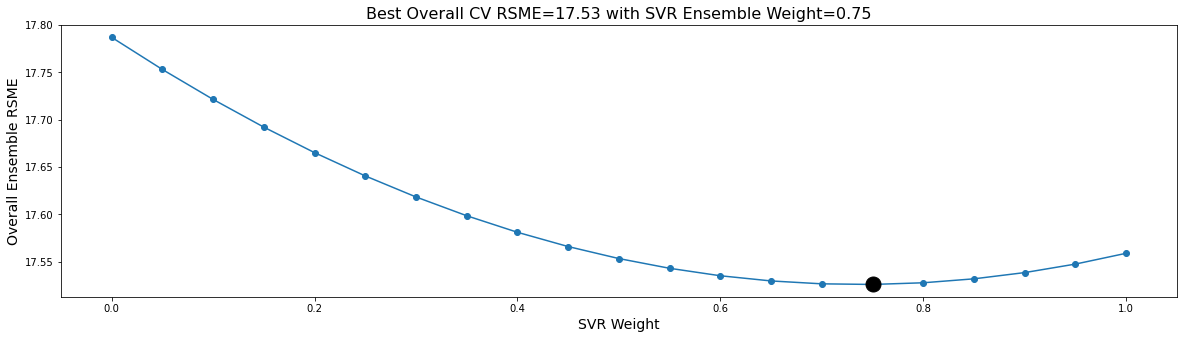

In [8]:
import matplotlib.pyplot as plt

score = []
for ww in np.arange(0,1.05,0.05):
    oof3 = (1-ww)*oof + ww*oof2
    rsme = np.sqrt( np.mean( (oof3 - true)**2.0 ))
    #print(f'{ww:0.2} CV Ensemble RSME =',rsme)
    score.append(rsme)
best_w = np.argmin(score)*0.05

plt.figure(figsize=(20,5))
plt.plot(np.arange(21)/20.0,score,'-o')
plt.plot([best_w],np.min(score),'o',color='black',markersize=15)
plt.title(f'Best Overall CV RSME={np.min(score):.4} with SVR Ensemble Weight={best_w:.2}',size=16)
plt.ylabel('Overall Ensemble RSME',size=14)
plt.xlabel('SVR Weight',size=14)
plt.show()
